In [44]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from fbprophet import Prophet

In [45]:
kblue = [50/256, 87/256, 164/256]
matplotlib.rcParams.update({'font.size': 16})

In [5]:
schiphol_data = pd.read_csv('./data/schiphol_millions_pax_monthly.csv', index_col = 0)

In [10]:
# make a nice date format for prophet
schiphol_data.index = [datetime.strptime(x, '%b-%Y') for x in schiphol_data.index]

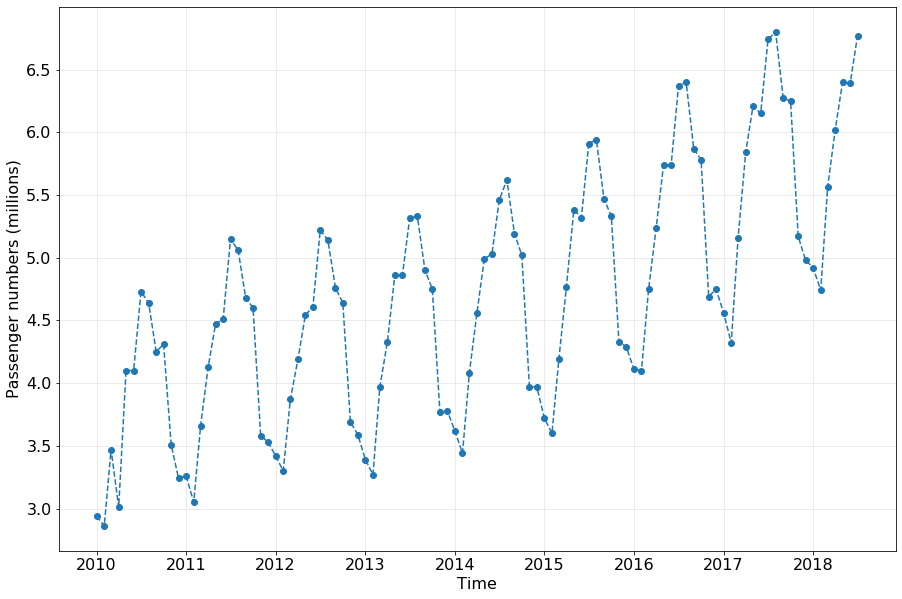

In [46]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.plot(schiphol_data, 'o--')
ax.set_xlabel('Time')
ax.set_ylabel('Passenger numbers (millions)')
ax.grid(True, color = [0.9, 0.9, 0.9, 0.1])
plt.savefig('./images/schiphol_data.png', bbox_inches = 'tight')
plt.show()

In [31]:
# prophet needs data in a very specific format
proph_df = pd.DataFrame(data = {'ds':schiphol_data.index, 'y': [x[0] for x in schiphol_data.values]})
# fit prophet
m = Prophet(mcmc_samples=300)
m.fit(proph_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
forecast = m.predict(proph_df)

In [36]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,3.670757,2.579909,2.968051,3.591991,3.747109,-0.893053,-0.958058,-0.825656,-0.893053,-0.958058,-0.825656,0.0,0.0,0.0,2.777704
1,2010-02-01,3.697561,2.436942,2.816763,3.622760,3.766291,-1.073917,-1.144815,-0.999114,-1.073917,-1.144815,-0.999114,0.0,0.0,0.0,2.623644
2,2010-03-01,3.721771,3.114933,3.473033,3.649860,3.788950,-0.421133,-0.488006,-0.350714,-0.421133,-0.488006,-0.350714,0.0,0.0,0.0,3.300638
3,2010-04-01,3.748575,3.494198,3.844920,3.682326,3.812371,-0.069518,-0.133076,-0.006906,-0.069518,-0.133076,-0.006906,0.0,0.0,0.0,3.679057
4,2010-05-01,3.775905,4.024438,4.394562,3.713685,3.836404,0.431818,0.370731,0.494284,0.431818,0.370731,0.494284,0.0,0.0,0.0,4.207724


In [37]:
proph_df_plus_pred = pd.merge(proph_df.set_index('ds'), forecast.set_index('ds'), left_index=True, right_index=True).reset_index()
proph_df_plus_pred['y_m_trend'] = proph_df_plus_pred['y']-proph_df_plus_pred['trend']

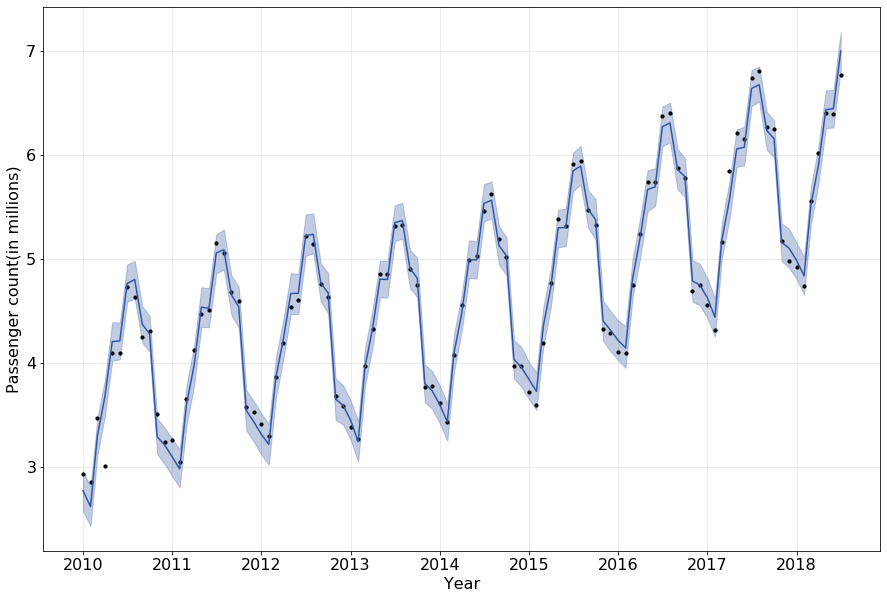

In [48]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.set_axisbelow(True)
ax.grid(True, color = [0.9, 0.9, 0.9, 0.1])
ax.fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['yhat_lower'], proph_df_plus_pred['yhat_upper'], color = kblue, alpha = 0.3)
ax.plot(proph_df_plus_pred['ds'], proph_df_plus_pred['yhat'], color = kblue)
ax.scatter(proph_df_plus_pred['ds'], proph_df_plus_pred['y'], color = 'k', s = 10)
ax.set_xlabel('Year')
ax.set_ylabel('Passenger count(in millions)')
plt.savefig('./images/schiphol_data_fit.png', bbox_inches = 'tight')
plt.show()

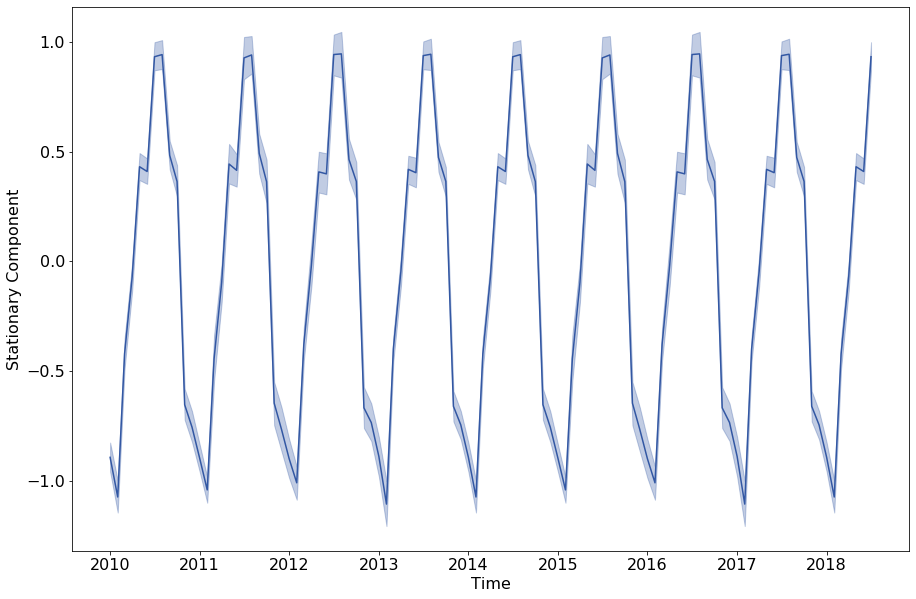

In [49]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['yearly_lower'], proph_df_plus_pred['yearly_upper'], color = kblue, alpha = 0.3)
ax.plot(proph_df_plus_pred['ds'], proph_df_plus_pred['yearly'], color = kblue)
ax.set_xlabel('Time')
ax.set_ylabel('Stationary Component')
plt.savefig('./images/schiphol_data_stationary.png', bbox_inches = 'tight')
plt.show()

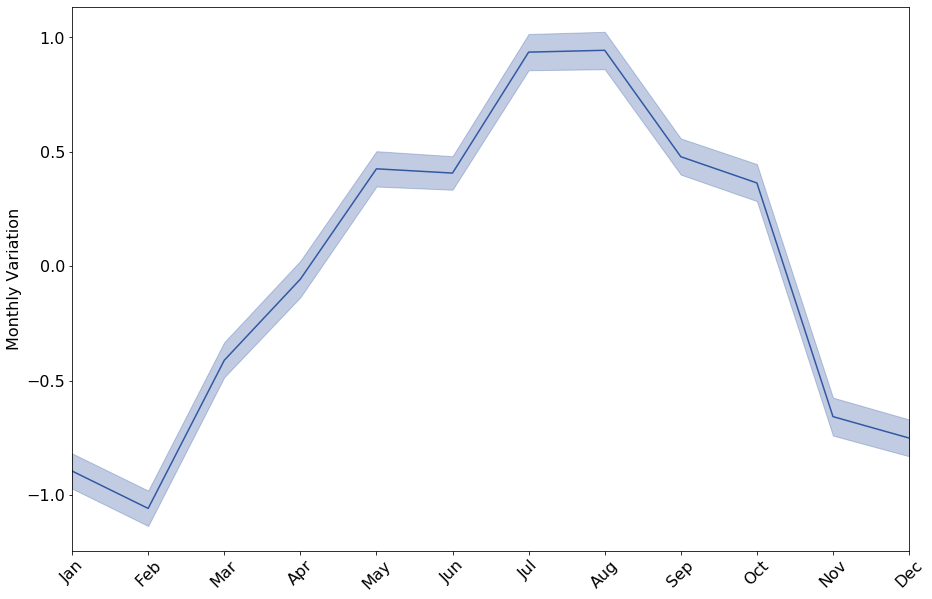

In [51]:
# Stationary Yearly 
yearly_pattern = proph_df_plus_pred['yearly'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
yearly_pattern_lower = proph_df_plus_pred['yearly_lower'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
yearly_pattern_upper = proph_df_plus_pred['yearly_upper'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
single_year = np.mean(yearly_pattern.reshape(int(len(yearly_pattern)/12),12), axis = 0)
single_year_lower = np.mean(yearly_pattern_lower.reshape(int(len(yearly_pattern)/12),12), axis = 0)
single_year_upper = np.mean(yearly_pattern_upper.reshape(int(len(yearly_pattern)/12),12), axis = 0)
single_year_std = np.std(yearly_pattern.reshape(int(len(yearly_pattern)/12),12), axis = 0)

fig, ax = plt.subplots(figsize = [15, 10])
month_array = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.fill_between(np.arange(0,len(month_array)), single_year_lower, single_year_upper, color = kblue, alpha = 0.3)
ax.plot(np.arange(0,len(month_array)), single_year,color = kblue)
ax.set_xticks(np.arange(0,len(month_array)))
ax.set_xticklabels(month_array, rotation = 45)
ax.set_ylabel('Monthly Variation')
ax.set_xlim(0, len(month_array)-1)
plt.savefig('./images/schiphol_data_monthly_variation.png', bbox_inches = 'tight')
plt.show()

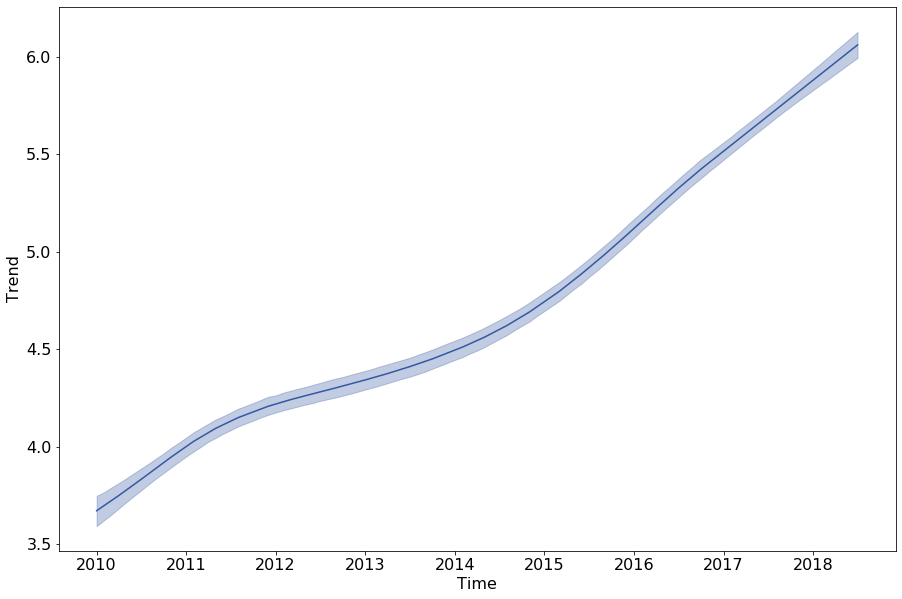

In [52]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['trend_lower'], proph_df_plus_pred['trend_upper'], color = kblue, alpha = 0.3)
ax.plot(proph_df_plus_pred['ds'], proph_df_plus_pred['trend'], color = kblue)
ax.set_xlabel('Time')
ax.set_ylabel('Trend')
plt.savefig('./images/schiphol_data_trend.png', bbox_inches = 'tight')
plt.show()

### Not so straight forward getting fbprophet installed

First run:
`conda install libpython m2w64-toolchain -c msys2`

Then:
`conda install pystan -c conda-forge`

Then go get prophet:
`conda install -c conda-forge fbprophet`

(N.B. some people found that a simple `conda config --set ssl_verify no` solved it)

All comes down to installing pystan: https://pystan.readthedocs.io/en/latest/windows.html#windows

Problem with Easter?

https://github.com/dr-prodigy/python-holidays/issues/277

In [32]:
# other stuff:

In [ ]:
def get_hist_plots(airport_choice= 'Schiphol', n_months_to_predict="1"):
  proph_df = pd.DataFrame(data = {'ds':nice_date_format, 'y': airport_data.loc[airport_choice].values})
  m = Prophet(mcmc_samples=300)
  m.fit(proph_df)
  n_months_to_predict = int(n_months_to_predict)-1
  
  # make a dataframe stretching into the future
  future = pd.DataFrame(data = {'ds' : pd.date_range(proph_df.ds.iloc[0], proph_df.ds.iloc[-1]+relativedelta(months=n_months_to_predict), freq = 'MS')})
  
  forecast = m.predict(future)

  proph_df_plus_pred = pd.merge(proph_df.set_index('ds'), forecast.set_index('ds'), left_index=True, right_index=True).reset_index()
  proph_df_plus_pred['y_m_trend'] = proph_df_plus_pred['y']-proph_df_plus_pred['trend']

  # do a train/test split 
  # This is just for the rmse code 
  date_range_to_sample_train = pd.date_range(proph_df.ds.iloc[0], proph_df.ds.iloc[-1]-relativedelta(months=1*n_months_to_predict), freq = 'MS')
  date_range_to_sample_test = pd.date_range(proph_df.ds.iloc[-1]-relativedelta(months=1*n_months_to_predict-1), proph_df.ds.iloc[-1], freq = 'MS')

  proph_df_train = proph_df[proph_df['ds'].isin(date_range_to_sample_train)]
  proph_df_test = proph_df[proph_df['ds'].isin(date_range_to_sample_test)]

  m_tt = Prophet(mcmc_samples=300)
  m_tt.fit(proph_df_train)
  predicted_tt = m_tt.predict(pd.DataFrame(data = {'ds':proph_df_test['ds'].values}))
  rmse = np.sqrt(np.sum((predicted_tt['yhat'].values-proph_df_test['y'].values)**2))/np.sqrt(len(proph_df_test))
  
  ###### PLOTS CODE ###########
  
  kempen_blue = [50/256, 87/256, 164/256]
  fig, ax = plt.subplots(6, 1, figsize = [15,20])
  
  # Overall plot
  ax[0].set_axisbelow(True)
  ax[0].grid(True, color = [0.9, 0.9, 0.9, 0.1])
  ax[0].fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['yhat_lower'], proph_df_plus_pred['yhat_upper'], color = kempen_blue, alpha = 0.3)
  ax[0].plot(proph_df_plus_pred['ds'], proph_df_plus_pred['yhat'], color = kempen_blue)
  ax[0].scatter(proph_df_plus_pred['ds'], proph_df_plus_pred['y'], color = 'k', s = 10)
  ax[0].set_xlabel('Year')
  ax[0].set_ylabel('Passenger count(in millions)')
   
  # Stationary 
  ax[1].fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['yearly_lower'], proph_df_plus_pred['yearly_upper'], color = kempen_blue, alpha = 0.3)
  ax[1].plot(proph_df_plus_pred['ds'], proph_df_plus_pred['yearly'], color = kempen_blue)
  ax[1].set_xlabel('Time')
  ax[1].set_ylabel('Stationary Component')
  
  # Stationary Yearly 
  yearly_pattern = proph_df_plus_pred['yearly'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
  yearly_pattern_lower = proph_df_plus_pred['yearly_lower'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
  yearly_pattern_upper = proph_df_plus_pred['yearly_upper'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
  single_year = np.mean(yearly_pattern.reshape(int(len(yearly_pattern)/12),12), axis = 0)
  single_year_lower = np.mean(yearly_pattern_lower.reshape(int(len(yearly_pattern)/12),12), axis = 0)
  single_year_upper = np.mean(yearly_pattern_upper.reshape(int(len(yearly_pattern)/12),12), axis = 0)
  single_year_std = np.std(yearly_pattern.reshape(int(len(yearly_pattern)/12),12), axis = 0)
  
  month_array = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
  ax[2].fill_between(np.arange(0,len(month_array)), single_year_lower, single_year_upper, color = kempen_blue, alpha = 0.3)
  ax[2].plot(np.arange(0,len(month_array)), single_year,color = kempen_blue)
  ax[2].set_xticks(np.arange(0,len(month_array)))
  ax[2].set_xticklabels(month_array, rotation = 45)
  ax[2].set_ylabel('Monthly Variation')
  ax[2].set_xlim(0, len(month_array)-1)
  
  # Trend 
  ax[3].fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['trend_lower'], proph_df_plus_pred['trend_upper'], color = kempen_blue, alpha = 0.3)
  ax[3].plot(proph_df_plus_pred['ds'], proph_df_plus_pred['trend'], color = kempen_blue)
  ax[3].set_xlabel('Time')
  ax[3].set_ylabel('Trend')

  go_back = 1
  date_range_to_sample_data = pd.date_range(proph_df.ds.iloc[-1]-relativedelta(months=go_back*n_months_to_predict), forecast.ds.iloc[-1], freq = 'MS')
  date_range_to_sample_fit = pd.date_range(proph_df.ds.iloc[-1], forecast.ds.iloc[-1], freq = 'MS')
  forecast_slice = forecast[forecast['ds'].isin(date_range_to_sample_fit)]
  data_slice = proph_df_plus_pred[proph_df_plus_pred['ds'].isin(date_range_to_sample_data)]

  ax[4].fill_between(forecast_slice['ds'], forecast_slice['yhat_lower'], forecast_slice['yhat_upper'], color = kempen_blue, alpha = 0.3)
  ax[4].plot(forecast_slice['ds'], forecast_slice['yhat'], color = kempen_blue)
  ax[4].plot(data_slice['ds'], data_slice['y'], 'o--', color = 'k', markersize = 6)
  ax[4].set_xlabel('Time')
  ax[4].set_ylabel('Predictions')
  
  # write rmse
  xlims = ax[4].get_xlim()
  ylims = ax[4].get_ylim()
  perc_x = 0.05
  perc_y = 0.9
  xpos = perc_x*(xlims[1]-xlims[0])+xlims[0]
  ypos = perc_y*(ylims[1]-ylims[0])+ylims[0]
  ax[4].text(xpos, ypos, 'RMSE$_{{ {} months}}$ = {:.3g} mil'.format(n_months_to_predict, rmse), size = 20)
  
  # Plot a table
  tbplot = pd.DataFrame({'date': forecast_slice['ds'].dt.strftime('%Y-%m'), 'prediction':forecast_slice['yhat'] })
  ax[5].table(cellText=tbplot.tail(8).as_matrix(),colLabels=['date', 'predictions'],loc='center')
  ax[5].grid(False)
  empty_string_labels = ['']*len(month_array)
  ax[5].set_xticks([])
  ax[5].set_yticks([])
  
  fig.tight_layout()
  return(fig)